# ENEL 645 - Assignment 4
## Adam Kerr - 10146363

In [41]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
import keras

## Part I. Time series classification: Data exploration and Learning with Deep Neural Network
### 1. Formatting raw data to Deep Convolutional Neural Network: Our raw data from the 6 attributes will be used. This means we will not be required to extract mean/std features from the raw data.
#### a. Please standardize the data before combining or stacking the attributes. (Note that all the reported attributes are measured in the same units (gravity) and in similar order of magnitude so standardizing may have marginal effects)


In [42]:
train_data = loadmat('DataSensors\\rawSensorData_train.mat')
test_data = loadmat('DataSensors\\rawSensorData_test.mat')

acc_x_train = train_data['total_acc_x_train']
acc_y_train = train_data['total_acc_y_train']
acc_z_train = train_data['total_acc_z_train']

gyro_x_train = train_data['body_gyro_x_train']
gyro_y_train = train_data['body_gyro_y_train']
gyro_z_train = train_data['body_gyro_z_train']

acc_x_test = test_data['total_acc_x_test']
acc_y_test = test_data['total_acc_y_test']
acc_z_test = test_data['total_acc_z_test']

gyro_x_test = test_data['body_gyro_x_test']
gyro_y_test = test_data['body_gyro_y_test']
gyro_z_test = test_data['body_gyro_z_test']

In [43]:
from sklearn.preprocessing import StandardScaler as ss
scaler = ss()

acc_x_train_scaled = scaler.fit_transform(acc_x_train)
acc_x_test_scaled = scaler.transform(acc_x_test)

acc_y_train_scaled = scaler.fit_transform(acc_y_train)
acc_y_test_scaled = scaler.transform(acc_y_test)

acc_z_train_scaled = scaler.fit_transform(acc_z_train)
acc_z_test_scaled = scaler.transform(acc_z_test)

gyro_x_train_scaled = scaler.fit_transform(gyro_x_train)
gyro_x_test_scaled = scaler.transform(gyro_x_test)

gyro_y_train_scaled = scaler.fit_transform(gyro_y_train)
gyro_y_test_scaled = scaler.transform(gyro_y_test)

gyro_z_train_scaled = scaler.fit_transform(gyro_z_train)
gyro_z_test_scaled = scaler.transform(gyro_z_test)

#### b. Consider each attribute in the training [7352,128] will be stacked in the “axis=2” dimension (counting from 0), often called an input channel. We use np.stack so we obtain [7352,128,6] array, corresponding to [axis=0,1,2] as [num_samples, num_timesteps, num_attributes]. 

In [44]:
train = np.stack([acc_x_train_scaled, 
                  acc_y_train_scaled, 
                  acc_z_train_scaled, 
                  gyro_x_train_scaled, 
                  gyro_y_train_scaled, 
                  gyro_z_train_scaled], axis=2)

train.shape

(7352, 128, 6)

#### c. Repeat for test data.

In [45]:
test = np.stack([acc_x_test_scaled, 
                 acc_y_test_scaled, 
                 acc_z_test_scaled, 
                 gyro_x_test_scaled, 
                 gyro_y_test_scaled, 
                 gyro_z_test_scaled], axis=2)

test.shape

(2947, 128, 6)

#### d. Convert labels (1 to 5) to 0 to 4, and perform one-hot encoding

In [46]:
from keras.utils import to_categorical

labels = loadmat('DataSensors\\labels.mat')
train_labels = labels['train_labels']
test_labels = labels['test_labels']

train_labels = np.subtract(train_labels, 1)
test_labels = np.subtract(test_labels, 1)

train_labels_enc = to_categorical(train_labels)
test_labels_enc = to_categorical(test_labels)

### 2. Implement the Deep Neural Network Classifier: Note the parameter and layer tuning is usually up to the designer, here is my architecture and tuning which converges. If your computer has “Out of memory” problem, consider reducing the number of neurons, and the batchsize in step h.
#### a. Use a Conv1D layer with 100 filters, a sliding kernel filter of 10, padding=’causal’, Relu activation, and input shape of [num_timesteps, num_attributes]


In [47]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D
from keras import regularizers, optimizers

In [48]:
model = Sequential()
model.add(Conv1D(100, 10,
                 padding='causal',
                 activation='relu',
                 input_shape=(128, 6)))

#### b. Add another Conv1D layer with 150 filters, sliding kernel of 20, padding=’causal’, Relu activation.

In [49]:
model.add(Conv1D(150, 20,
                 padding='causal',
                 activation='relu'))

#### c. Use the “GlobalAveragePooling1D” to reduce the convolutional output to a 1D vector to use as features to a standard neural network (dense layer and output)

In [50]:
model.add(GlobalAveragePooling1D())

#### d. Add a dense layer with 128 neurons, followed by ‘relu” activation

In [51]:
model.add(Dense(128))
model.add(Activation('relu'))

#### e. Add a dropout layer with dropout probability of 50%.

In [52]:
model.add(Dropout(0.5))

#### f. In the output layer, specify a N=5 neuron output, with ‘softmax’ activation.

In [53]:
model.add(Dense(5))
model.add(Activation('softmax'))

#### g. Compile the model, using ‘adam’ optimizer, loss as ‘categorical_crossentropy’, and metrics of [‘accuracy’].

In [54]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### h. Fit (train) the model using the training [7352,128,6] features and train_label for 20 epoch. Specify a batch_size=256. (or smaller batch_size depending on your hardware)

In [55]:
history = model.fit(train, train_labels_enc, batch_size=256, epochs=20)

Epoch 1/20
7352/7352 [==============================] - 1s 113us/step - loss: 0.7346 - acc: 0.6820
Epoch 2/20
7352/7352 [==============================] - 0s 55us/step - loss: 0.2714 - acc: 0.8953
Epoch 3/20
7352/7352 [==============================] - 0s 54us/step - loss: 0.1813 - acc: 0.9323
Epoch 4/20
7352/7352 [==============================] - 0s 55us/step - loss: 0.1500 - acc: 0.9418
Epoch 5/20
7352/7352 [==============================] - 0s 55us/step - loss: 0.1304 - acc: 0.9468
Epoch 6/20
7352/7352 [==============================] - 0s 54us/step - loss: 0.1180 - acc: 0.9502
Epoch 7/20
7352/7352 [==============================] - 0s 55us/step - loss: 0.1178 - acc: 0.9509
Epoch 8/20
7352/7352 [==============================] - 0s 56us/step - loss: 0.1083 - acc: 0.9542
Epoch 9/20
7352/7352 [==============================] - 0s 54us/step - loss: 0.1076 - acc: 0.9508
Epoch 10/20
7352/7352 [==============================] - 0s 55us/step - loss: 0.1072 - acc: 0.9535
Epoch 11/20
7352/7

#### i. Evaluate the results of the model on the [2549,128,6] test feature and test_label.

In [56]:
test_loss, test_acc = model.evaluate(test,  test_labels_enc, verbose=2)
print('\nTest loss:', test_loss)  
print('\nTest accuracy: %f %%' % (test_acc * 100))


Test loss: 0.33153717248077685

Test accuracy: 92.670512 %


### 3. Answer the following questions:
#### a. Print the model.summary(). For each layer, using the output shape as a guide, verify the number of parameters (Param #) is correct.
##### i. Hint 1: In the conv layers, each filter has a certain number of neurons for the convolution weights per [num_attributes],
##### ii. Hint 2: https://keras.io/layers/pooling/
##### iii. Hint 3: Dense layers: output = Wx+b

In [57]:
model.summary()
print("Layer 1: 6 input channels * 10 weights (kernel width) * 100 filters + 100 biases (1 per filter) = %d" % (6*10*100+100))
print("Layer 2: 100 inputs (filters) * 20 weights (kernel width) * 150 filters + 150 biases (1 per filter) = %d" % (100*20*150+150))
print("Layer 3: 150 inputs (filters) * 128 outputs + 128 biases = %d" % (150*128+128))
print("Layer 4: 128 inputs * 128 outputs + 128 biases = %d" % (128*128+128))
print("Layer 5: 128 inputs * 5 outputs + 5 biases = %d" % (128*5+5))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 128, 100)          6100      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 128, 150)          300150    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               19328     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
__________

#### b. Plot the training cross entropy loss, the training accuracy with the number of epoch (full iterations over dataset) in the data.

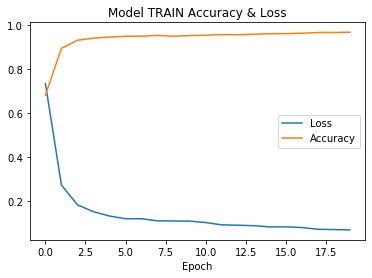

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('Model TRAIN Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='right')
plt.show()

#### c. Output the confusion matrix and accuracy for both training and test data with deep neural network.

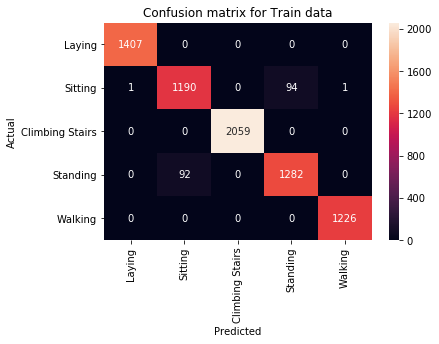

Train accuracy for Network: 97.442873 %


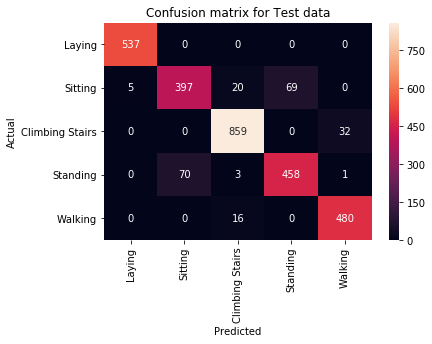

Test accuracy for Network: 92.670512 %


In [59]:
from sklearn.metrics import confusion_matrix

pred_train = model.predict(train)
pred_test = model.predict(test)

pred_train = np.array([np.argmax(x) for x in pred_train])
pred_test = np.array([np.argmax(x) for x in pred_test])

incorrect_train = (pred_train != train_labels.reshape(-1,)).sum()
incorrect_test = (pred_test != test_labels.reshape(-1,)).sum()

num_train = len(train_labels)
num_test = len(test_labels)

label_names = ['Laying', 'Sitting', 'Climbing Stairs', 'Standing', 'Walking']

fig, ax = plt.subplots()
cm = confusion_matrix(train_labels.reshape(-1,), pred_train)
df_cm = pd.DataFrame(cm, label_names, label_names)
sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_ylim(5.0,0.0)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.title('Confusion matrix for Train data')
plt.show()

print("Train accuracy for Network: %f %%" % (((num_train - incorrect_train) / num_train) * 100))

fig, ax = plt.subplots()
cm = confusion_matrix(test_labels.reshape(-1,), pred_test)
df_cm = pd.DataFrame(cm, label_names, label_names)
sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_ylim(5.0,0.0)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.title('Confusion matrix for Test data')
plt.show()

print("Test accuracy for Network: %f %%" % (((num_test - incorrect_test) / num_test) * 100))

#### d. Output the softmax probability of the first 5 test samples and compare with true label.

In [60]:
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

predictions = model.predict(test[:5])
print(predictions)

print('Predicted: ',[np.argmax(x) for x in predictions])
print('Actual: ', test_labels[:5].reshape(-1))

[[0.00000 0.00000 0.00000 1.00000 0.00000]
 [0.00000 0.00002 0.00001 0.99997 0.00000]
 [0.00000 0.00005 0.00001 0.99994 0.00000]
 [0.00000 0.00005 0.00000 0.99995 0.00000]
 [0.00000 0.00005 0.00000 0.99995 0.00000]]
Predicted:  [3, 3, 3, 3, 3]
Actual:  [3 3 3 3 3]


#### e. For the deep neural network, based on confusion matrix and previous analysis, which classes of activities are the most difficult and which ones conversely are easy to “classify”?

Laying is the easiest class to classify while the others are more difficult. The network tends to confuse sitting and standing, as well as walking and climbing stairs. It also occasionally confuses sitting as climbing stairs and very rarely standing as climbing stairs.

#### f. What parameters are modifiable to the analyst in a deep neural network? You may use terminology used in the Keras libraries to guide your answer.

There are very many ways to customize the neural network. You can change the learning rate, batch size, number of epochs, number of layers, number of neurons in each layer, types of layers, types of activation, regularization, optimizers, loss functions, and performance metrics. Each of these options can be customized with a variety of hyperparameters.

#### g. Discuss any advantages or applications of using convolutional layers over choosing hand-crafted statistical features (i.e. mean, standard deviation). *Note that the current dataset, the task (predicting the activity) is already quite separable with the hand-crafted features [Assignment 3 from the 3D plots].

The advantage of using convolutional networks is that the features are learned by the classifier. This can be very beneficial if it isn't particularly clear how to select features. For a complex task like image recognition there could easily be a very large number of features required for good performance. This simply wouldn't be feasibly for anyone to handcraft.